In [1]:
#helper function
from qiskit import execute, BasicAer, QuantumCircuit, QuantumRegister, ClassicalRegister
def simulate(qc, name="q", x="0", n=None, verbose=False):
	backend = BasicAer.get_backend('qasm_simulator')
	if n is None: 
		n = qc.num_qubits

	reg = QuantumRegister(n, name)
	qc2 = QuantumCircuit(reg)
	for i, j in enumerate(x):
		if j == "1": 
			qc2.x(i)
		elif j == "+":
			qc2.h(i)


	qc2 += qc.copy()
	if verbose: 
		print(qc2)
	results = execute(qc2, backend=backend, shots=1000).result()
	return results.get_counts()

In [17]:
#helper function
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

def run(qc, dev="best", verbose=False):

    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    if dev == "best":
        backend = least_busy(provider.backends(simulator=False))
    else:
        backend = provider.get_backend(dev)


    if verbose: print(backend)
    job_exp = execute(qc, backend=backend, shots=1024)
    exp_result = job_exp.result()
    return exp_result.get_counts(qc)

Controlled swap gate with |+> as control

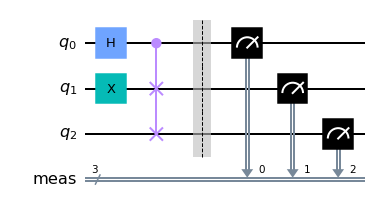

In [2]:

qc = QuantumCircuit(3)
qc.h(0)
qc.x(1)
qc.cswap(0,1,2)
qc.measure_all()
qc.draw(output='mpl')

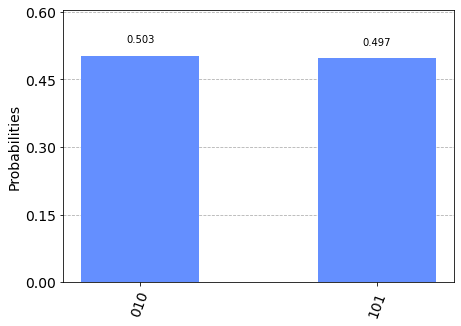

In [3]:
from qiskit.visualization import plot_histogram
plot_histogram(simulate(qc))

#### Half the time the control is 1 and the swap happens
#### Half the time it doesnt

#### This can be used to conditionally measure a qubit:

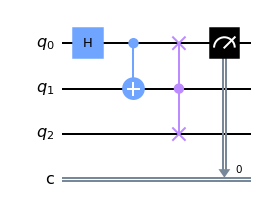

In [4]:
qc = QuantumCircuit(3,1)
qc.h(0)
qc.cx(0,1)
qc.cswap(1,0,2)
qc.measure(0, 0)
qc.draw(output='mpl')

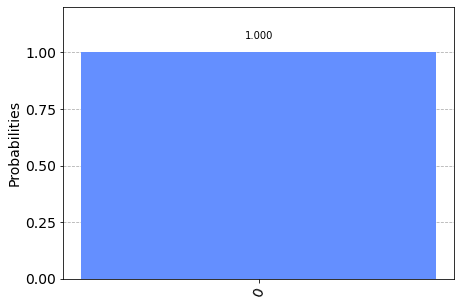

In [5]:
plot_histogram(simulate(qc))

#### measures q0 iff it will be zero. (otherwise doesnt measure anything so result is 0)

#### This is more useful for greater number of qubits. Consider measuring two qubit iff they will are in state |11>

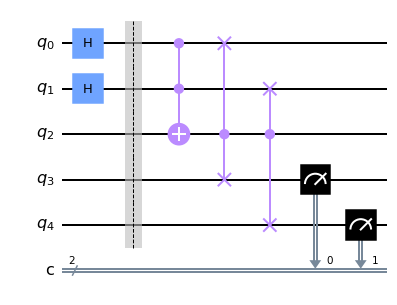

In [6]:
qc = QuantumCircuit(5,2)

qc.h(0)
qc.h(1)

qc.barrier()

qc.ccx(0,1,2)
qc.cswap(2,0,3)
qc.cswap(2,1,4)

qc.measure(3,0)
qc.measure(4,1)

qc.draw(output='mpl')

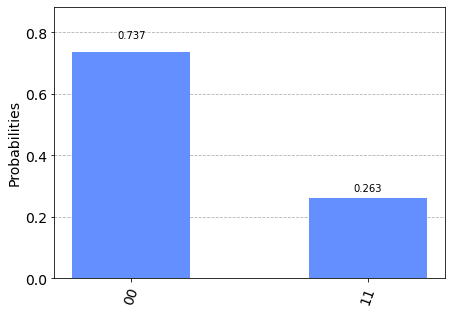

In [7]:
plot_histogram(simulate(qc))

#### It measures 11 1/4 of the time and measures 00 3/4 (when the state is 00, 01 or 10)

#### Question: Is there a way to increase the probability of measuring 11?

#### Answer: Yes! (grover's algorithm)


Helper function which creates grovers circuit assuming answer is "1" * n and option to add conditional measurement

In [8]:
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import CustomCircuitOracle
import string

def get_grovers(n, cm=True, iterations=1):

    orac = QuantumCircuit(QuantumRegister(n,name="main"), QuantumRegister(1,name="o"))
    orac.mct(list(range(n)), n)
    def classic(x):
        assert type(x) == str, x
        return True, ["1" * n]



    qc = QuantumCircuit()
    
    main = QuantumRegister(n, name="main")
    qc.add_register(main)

    #a = QuantumRegister(1, name="anc")
    #qc.add_register(a)    
        
    out = QuantumRegister(1, name="o")
    qc.add_register(out)


    o = CustomCircuitOracle(variable_register=main, output_register=out, circuit=orac, evaluate_classically_callback=classic)#, ancillary_register=a)
    
    grov = Grover(o, iterations=iterations)
        
    g = grov.construct_circuit()#.to_gate()
    g.name = "Grover"
    
    #print(g)
    #print(list(range(g.num_qubits)))
    #qc.append(g, list(range(n)) + [qc.num_qubits-1, qc.num_qubits-2])
    qc.append(g, list(range(g.num_qubits)))


    qc.add_register(ClassicalRegister(n))
    
    if cm:
        qc.add_register(QuantumRegister(n, name="b"))
        qc.add_register(QuantumRegister(1, name='cm'))
        qc.mct(list(range(n)), qc.num_qubits-1)

    for j in range(0,n):
        if cm:
            qc.cswap(qc.num_qubits-1,j,j+n+1)
            qc.measure(j+n+1,j)
        else:
            qc.measure(j,j)

    return qc



For 2 qubits, makes no difference

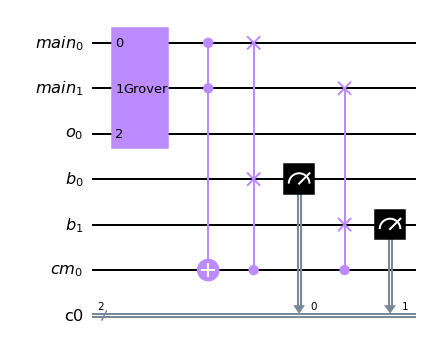

In [9]:
qc = get_grovers(2)
qc.draw(output='mpl')

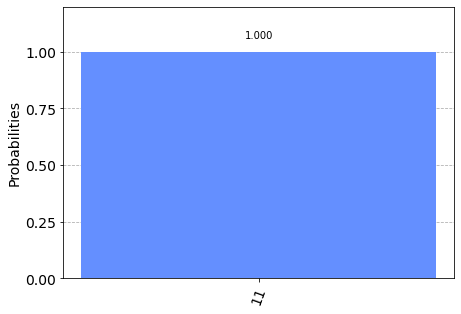

In [10]:
plot_histogram(simulate(qc))

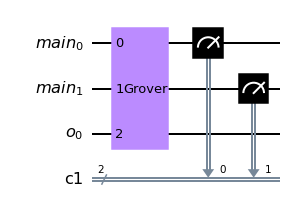

In [11]:
qc = get_grovers(2, cm=False)
qc.draw(output='mpl')

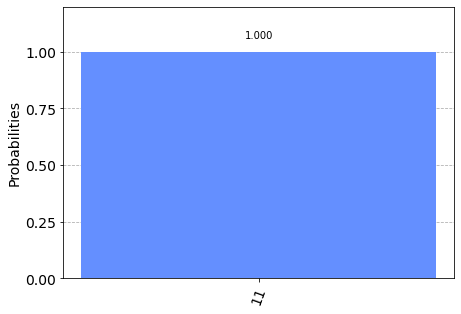

In [12]:
plot_histogram(simulate(qc))

### For three qubits, conditional measurement starts to make a difference

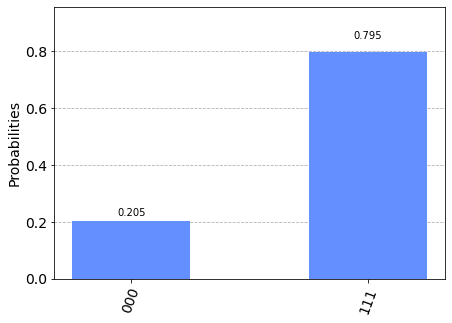

In [13]:
plot_histogram(simulate(get_grovers(3)))

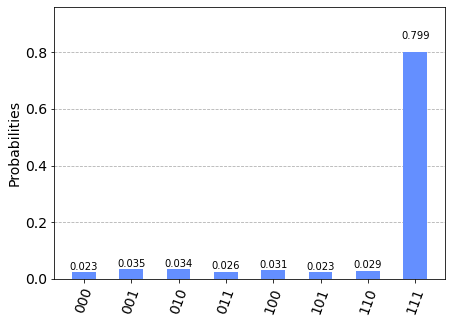

In [14]:
plot_histogram(simulate(get_grovers(3,False)))

### The proportion of the correct answer is the same, but all of the incorrect answers are grouped into 000

### This becomes increasingly useful as n increases:

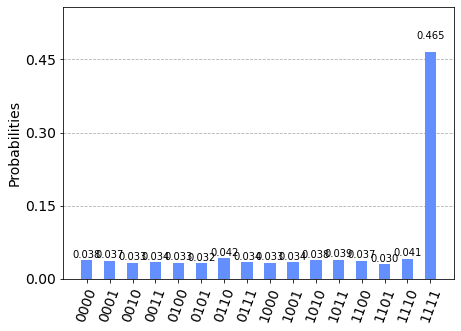

In [15]:
plot_histogram(simulate(get_grovers(4,False)))

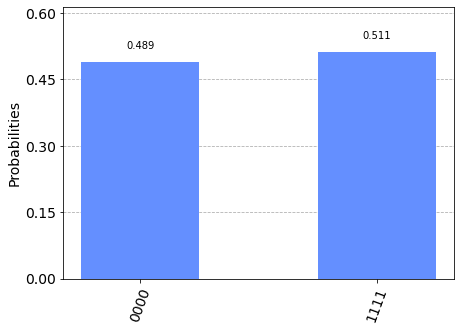

In [16]:
plot_histogram(simulate(get_grovers(4)))

Real devices are too noisy:

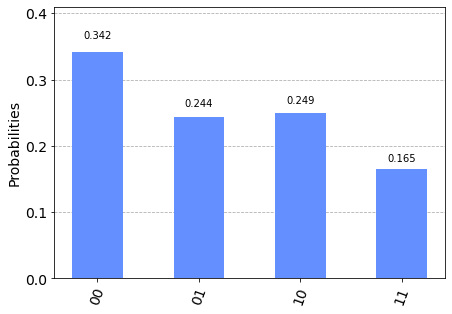

In [20]:
plot_histogram(run(get_grovers(2), dev="ibmq_16_melbourne"))

#### For most effective usage, a classical-quantum hybrid version could be made which runs the circuit for as long as 00... is measured